In [ ]:
from google.colab import drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    workspace = '/content/drive/MyDrive'
except:
    workspace = '.'
!pip install torch==1.7.0 torchvision==0.8.0 torchaudio==0.7.0
%pip install -U opencv-python
%pip install -U opencv-contrib-python
%pip install -U grad-cam
%pip install eniops
%pip install vit-pytorch

Mounted at /content/drive
     |████████████████████████████████| 776.7 MB 4.4 kB/s 
     |████████████████████████████████| 11.8 MB 28.8 MB/s 
     |████████████████████████████████| 7.6 MB 32.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which 

     |████████████████████████████████| 60.5 MB 52.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 66.7 MB 28 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 4.5 MB 2.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████

ERROR: Could not find a version that satisfies the requirement eniops (from versions: none)
ERROR: No matching distribution found for eniops
     |████████████████████████████████| 52 kB 605 kB/s 


# Image Classification 3

This tutorial is mainly for presentation. We will learn the usage of grad-CAM and an example of using ViT to do simple classification.

## 1. Grad-CAM
We have learnt some Deep Learning methods to do the image classification task. The advantage of Deep Learning for most of us is that we can build complex models by simply stacking layers. But how can we tell if the models are working properly? We can use Grad-CAM to help us show the attention of the neural networks.

This time, we will use the network used in tutorial 6 to show the results of CAM algorightm. 

Firstly, we still need to load the data including images and labels.

In [ ]:
# load the images
import os
import csv
import cv2
import numpy as np
from sklearn import datasets
from pprint import pprint
from collections import namedtuple
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

root = os.path.join(workspace, 'Tutorial-6/')
label_path = os.path.join(root, 'label.csv')

 
def labels2strs(labels: list) -> list:
    lengths = np.max([[len(j) for j in i] for i in labels], axis=0)
    format_str = ' '.join(['{:^%ds}'%length for length in lengths])
    seps = ' '.join(['-'*length for length in lengths])
    contents = [format_str.format(*row) for row in labels]
    contents.insert(1, seps)
    return contents

if os.path.exists(label_path):
    with open(label_path) as f:
        flabels = list(csv.reader(f))
    print(*labels2strs(flabels), sep='\n')
else:
    raise ValueError('Invalid label file path [%s]'%label_path)


samples = {'train': [], 'val': []}

class Sample:
    def __init__(self, idx=0, fname='', img=None, feat=None, label=None):
        self.idx = idx
        self.fname = fname
        self.img = img
        self.feat = feat
        self.label = label
        self.pred = None

for idx, fname, label, split in flabels[1:]:
    idx, label = int(idx), int(label)
    if idx % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, idx%4+1)
    plt.title(f'{fname} in G{label}({split})')

    fpath = os.path.join(root, fname)
    if not os.path.isfile(fpath):
        raise ValueError('%s not found' % fpath)
    else:
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
        if idx == 0:
          H, W, C = img.shape
        else:
          img = cv2.resize(img, (W, H))
        
        plt.imshow(img)
        
        samples[split].append(Sample(idx, fname, img, None, label))

ID filename label split
-- -------- ----- -----
0   1.jpg     1   train
1   2.jpg     0    val 
2   3.jpg     1   train
3   4.jpg     1   train
4   5.jpg     0   train
5   6.jpg     0   train
6   7.jpg     0    val 
7   8.jpg     0   train
8   9.jpg     1   train
9   10.jpg    1    val 
10  11.jpg    0    val 
11  12.jpg    1   train
12  13.jpg    1    val 
13  14.jpg    0   train


Then we train the model with same experiment settings with tutorial 6. But there are some differences because grad-CAM method requires gradients so the layers should computed gradients in training, so we will not fix the weights of lower layers this time.

In [ ]:
from torch.functional import Tensor
from skimage import feature
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import time
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

def img_transform(img_rgb, transform=None):
    """
    transform images
    :param img_rgb: PIL Image
    :param transform: torchvision.transform
    :return: tensor
    """

    if transform is None:
        raise ValueError("there is no transform")

    img_t = transform(Image.fromarray(img_rgb))
    return img_t

train_imgs = [img_transform(sample.img, inference_transform) for sample in samples['train']]
train_imgs = torch.stack(train_imgs, dim=0)
test_imgs = [img_transform(sample.img, inference_transform) for sample in samples['val']]
test_imgs = torch.stack(test_imgs, dim=0)

train_labels = [sample.label for sample in samples['train']]
train_labels = torch.tensor(train_labels)

# define a classifier following the network
class classification_head(nn.Module):
	def __init__(self,in_ch,num_classes):
		super(classification_head,self).__init__()
		self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
		self.fc = nn.Linear(in_ch,num_classes)

	def forward(self, x):
		x = self.avgpool(x)
		x = torch.flatten(x, 1)
		x = self.fc(x)
		return x

#define ResNet model
class Net(nn.Module):
	def __init__(self, input_ch, num_class,pretrained=True):
		super(Net,self).__init__()
		model = models.resnet50(pretrained=pretrained)
		self.backbone =  nn.Sequential(*list(model.children())[:-2]) #remove the last Avgpool and Fully Connected Layer
		self.classification_head = classification_head(2048, num_class)
										
	def forward(self,x):
		x = self.backbone(x)
		output = self.classification_head(x)
		return output

# creat a model
model = Net(3, 2)
# fix the weights of ResNet
# for p in model.backbone.parameters():
#   p.requires_grad = False

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.train()

# training
num_epochs = 300
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = Variable(train_imgs).cuda()
        target = Variable(train_labels).cuda()
    else:
        inputs = Variable(train_imgs)
        target = Variable(train_labels)
 
    # forward
    out = model(inputs)
    loss = criterion(out, target)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch[20/300], loss: 0.000019
Epoch[40/300], loss: 0.000005
Epoch[60/300], loss: 0.000002
Epoch[80/300], loss: 0.000002
Epoch[100/300], loss: 0.000001
Epoch[120/300], loss: 0.000001
Epoch[140/300], loss: 0.000001
Epoch[160/300], loss: 0.000001
Epoch[180/300], loss: 0.000001
Epoch[200/300], loss: 0.000001
Epoch[220/300], loss: 0.000001
Epoch[240/300], loss: 0.000000
Epoch[260/300], loss: 0.000000
Epoch[280/300], loss: 0.000000
Epoch[300/300], loss: 0.000000


After we train the model succesfully, we can use the cam library to load a grad_cam model and then apply it to the resnet50 we have trained. And we finally show the visualization.

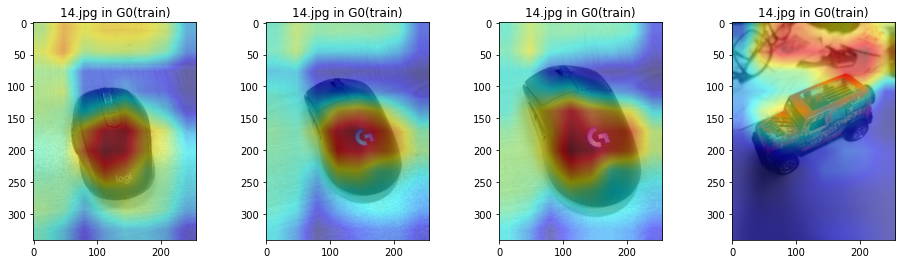

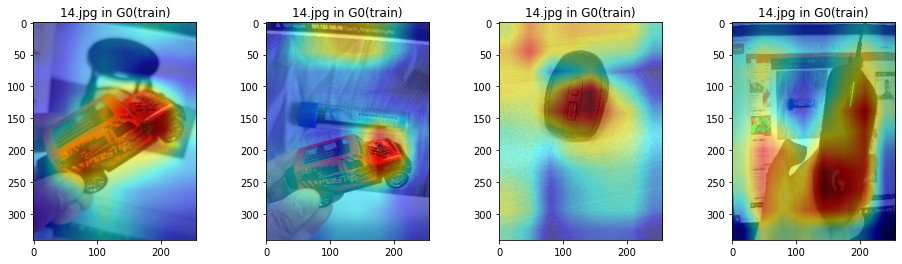

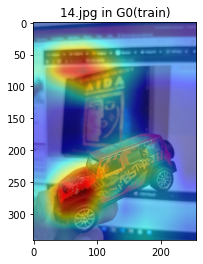

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.models import resnet50

target_layers = [model.backbone[-1][-1]]
inputs = []
imgs = []
for sample in samples['train']:
  rgb_img = sample.img
  rgb_img = cv2.resize(rgb_img, (256, 341))
  rgb_img = np.float32(rgb_img) / 255
  imgs.append(rgb_img)
  inputs.append(preprocess_image(rgb_img, mean=norm_mean,
                                    std=norm_std))

input_tensor = torch.cat(inputs, dim=0)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cams = cam(input_tensor=input_tensor,
                        targets=None)

# In this example grayscale_cam has only one image in the batch:
for i, img in enumerate(imgs):
  if i % 4 == 0:
      plt.figure(figsize=(16, 4))
  plt.subplot(1, 4, i%4+1)
  plt.title(f'{fname} in G{label}({split})')

  grayscale_cam = grayscale_cams[i, :]
  visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
  plt.imshow(visualization)

These images have shown which areas have been focused in the testing process of the trained resnet50. You can see that important objects such as mouse and car  or obvious blank area has been paid attention to by the neural network.

## 2. ViT
After seeing the how well the objects are focused or not by CAM methods, we can consider using some mechanism to help neural networks naturally recognize interesting area and pixels and focus on them with weight parameters learning. Transformer has provided this mechanism, and the keypoint in this model is the attention module.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

We can see the attention module map three matrices Q, K and V using the input data. The dot products of Q and K are normalized by softmax to represent the weight matrix and V represents the value matrix.

And the following are the complete ViT architecture.

In [ ]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

After defining the architecture, we can create a ViT model and this time we will use it to do the classification in tutorial 6. 

We train it using same training setting with the resnet50.

In [ ]:
v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

inputs = []
for sample in samples['train']:
  rgb_img = sample.img
  rgb_img = cv2.resize(rgb_img, (256, 256))
  rgb_img = np.float32(rgb_img) / 255
  imgs.append(rgb_img)
  inputs.append(preprocess_image(rgb_img, mean=norm_mean,
                                    std=norm_std))

train_imgs = torch.cat(inputs, dim=0)

v.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, v.parameters()), lr=0.001)
v.train()

# training
num_epochs = 100
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = Variable(train_imgs).cuda()
        target = Variable(train_labels).cuda()
    else:
        inputs = Variable(train_imgs)
        target = Variable(train_labels)
 
    # forward
    out = v(inputs)
    loss = criterion(out, target)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))


Epoch[20/100], loss: 0.401100
Epoch[40/100], loss: 0.000418
Epoch[60/100], loss: 0.000066
Epoch[80/100], loss: 0.000048
Epoch[100/100], loss: 0.000045


After successfully training, we test this model on validation set.

In [ ]:
#testing

inputs = []
for sample in samples['val']:
  rgb_img = sample.img
  rgb_img = cv2.resize(rgb_img, (256, 256))
  rgb_img = np.float32(rgb_img) / 255
  imgs.append(rgb_img)
  inputs.append(preprocess_image(rgb_img, mean=norm_mean,
                                    std=norm_std))

val_imgs = torch.cat(inputs, dim=0)
val_labels = [sample.label for sample in samples['val']]
val_labels = torch.tensor(val_labels)

v.eval()
with torch.no_grad():
        results = v(Variable(val_imgs))
        _, preds = torch.max(results, dim=1)
        total = results.size(0)
        correct=(preds==val_labels).sum().item()
print('acc on val set:%d%%'%(100*correct/total))
# display the results
for sample, pred in zip(samples['val'], preds):
    sample.pred = pred
    print(sample.fname, 'with label', sample.label, 'is predicted as', sample.pred)


acc on val set:100%
2.jpg with label 0 is predicted as tensor(0)
7.jpg with label 0 is predicted as tensor(0)
10.jpg with label 1 is predicted as tensor(1)
11.jpg with label 0 is predicted as tensor(0)
13.jpg with label 1 is predicted as tensor(1)


The accuracy is 100%, so it is obvious that ViT has great feature extracting ability.

##3. MNIST
Besides a simple classfication based on data used in tutorial 6, we can use another small-scale common used dataset used in computer vision MNIST. It consists of 70000 images of digtis. Here we can use vit to do the classification task on MNIST.

Firstly, we import the MNIST dataset from torchvision library, and use DataLoader to load the data from dataset for the following training.

In [ ]:
import torchvision
from torch.utils.data import DataLoader

n_epochs = 1
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize(32),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

From the example data we can see the shape of image has been changed to 32x32. And each image contains a label indicateing digit. And we can show some example images in MNIST as following:

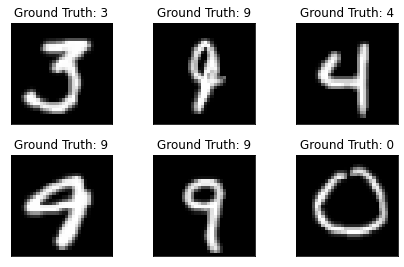

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Then we can define a ViT for corresponding image size and class numbers. Then train it with iterabal dataloader about a few epochs, and test the model to see the effectiveness of ViT in computer vision.

In [ ]:
import torch.nn.functional as F

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

vit = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    channels = 1,
    depth = 4,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, vit.parameters()), lr=0.001)

def train(epoch):
  vit.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = vit(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(v.state_dict(), './model.pth')
      # torch.save(optimizer.state_dict(), './optimizer.pth')

def test():
  vit.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = vit(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Due to limitation of computation resource, we do not train the model for many epochs, if you are interested, you can try run this code and get the predictions.